# Convolution basics

In this script we see the basics of convolution function and its parameters, and the main operations/layers used in convolutional neural networks.

Check the documentation for more details: https://pytorch.org/docs/stable/nn.html#convolution-layers

In [1]:
import torch
import torch.nn as nn
import numpy as np
from skimage import io
from matplotlib import pyplot as plt

(343, 550)


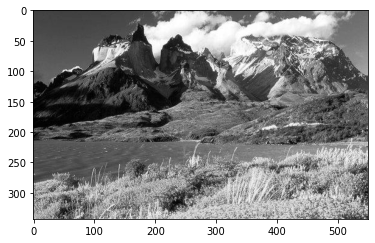

In [2]:
# Load an example image, and normalize it so the values ranges in [0, 1]
image_np = io.imread('tdp.jpeg')
image_np = image_np / np.max(image_np)

# Since it's a black and white image, all RGB channels are the same, so keep only one
image_np = image_np[:, :, 0]
print(image_np.shape)

# Display the image
plt.imshow(image_np, cmap='gray')
plt.show()

In [3]:
# Convert the image into a pytorch float tensor
image_t = torch.tensor(image_np).float()

# When we manipulate image data with pytorch, the size usually has to be (batch_size, num_channels, height, width)
# So, we have to add extra dimensions (unsqueeze) corresponding to the batch_size and num_channels
image_t = image_t.unsqueeze(0).unsqueeze(0)
print(image_t.shape)

torch.Size([1, 1, 343, 550])


### Convolution

Convolution is a mathematical operation which corresponds to applying a "filter" to some input data (e.g., an image). Here we will manipulate only 2D convolution, which are central in image processing. The "filter" (also called "kernel") is a small matrix that slides over the input image and is multiplied by it to produce the output image:

<img src="https://miro.medium.com/max/1400/1*_GfG3qc4C93q1BOmLBJqTA.png" />
<center><a href="https://medium.com/nerd-for-tech/convolutional-networks-b54335f4e21f">Source</a></center>

Note that there are other types of convolution, which are more appropriate for other data types. For instance, in audio, we use 1D convolution, which slides over 1 dimension (time). In video, we use 3D convolution, which slides over 3 dimensions (height, width, and time).

In [4]:
# To create the convolution function, we specify:
# - the number of input channels (= the depth of the input image, usually 1 for black and white images, and 3 for RGB color images
# - the number of output channels (which is equal to the number of kernels)
# - the kernel size (the dimension of the filter)
# - weather we use bias or not
num_channels_in = 1
num_channels_out = 1
kernel_size = 2
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=kernel_size, bias=False)

# You can print the kernel weights: when using Conv2d, the weights are randomly initialized
print(my_conv.weight)

Parameter containing:
tensor([[[[ 0.4857, -0.0388],
          [ 0.0819,  0.3986]]]], requires_grad=True)


In [5]:
# It is possible to set the value of the kernel weights.
# For instance, let us set all of them to 1
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight))
print(my_conv.weight)

Parameter containing:
tensor([[[[1., 1.],
          [1., 1.]]]], requires_grad=True)


(342, 549)


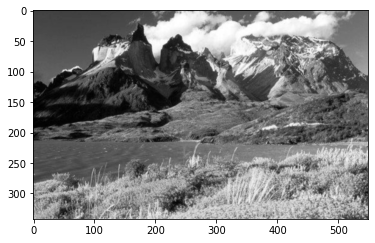

In [6]:
# Pass the image to the convolution
output = my_conv(image_t)

# Squeeze the output to remove the useless dimensions (batch_size and num_channels), and go back to numpy
output_np = output.squeeze().detach().numpy()

# Plot the output image
print(output_np.shape)
plt.imshow(output_np, cmap='gray')
plt.show()

# Since we set the kernel weights to 1, this convolution is equivalent to summing
# the adjacent pixels: the output image is then slightly blurred

Shape with kernel size=5:  (339, 546)


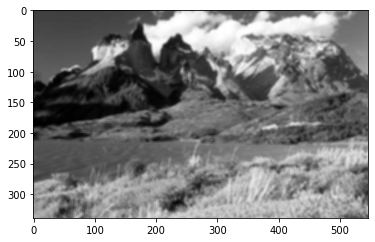

Shape with kernel size=10:  (334, 541)


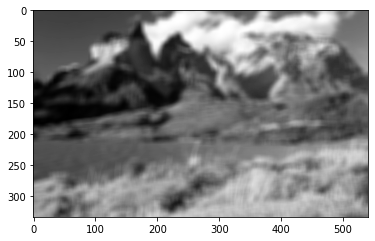

Shape with kernel size=20:  (324, 531)


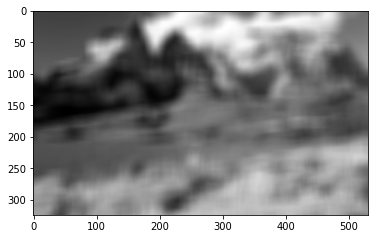

In [7]:
# TO DO:
# - create a convolution layer as above, (1 input and output channel, no bias)
# - change the size of the kernel (try 5, 10, and 20).
# - set the kernel weights at 1.
# - apply convolution to the input image
# - plot the output images and print its shape. What do you see?

def conv_variable_kernel_size(image_t, kernel_size, num_channels_in=1, num_channels_out=1):
    my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=kernel_size, bias=False)
    my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
    output = my_conv(image_t)
    output_np = output.squeeze().detach().numpy()

    return output_np

for k_size in [5, 10, 20]:
    output_np = conv_variable_kernel_size(image_t, k_size)
    print('Shape with kernel size=' + str(k_size) + ': ', output_np.shape)
    plt.imshow(output_np, cmap='gray')
    plt.show()


Shape : (343, 531)


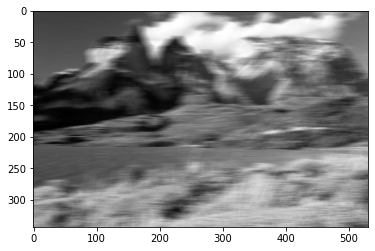

In [8]:
# We can use rectangular (= non-square) kernels, with a different lengths in height and width
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(1, 20))
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
output = my_conv(image_t)
output_np = output.squeeze().detach().numpy()

print('Shape :', output_np.shape)
plt.imshow(output_np, cmap='gray')
plt.show()

torch.Size([1, 1, 343, 550])


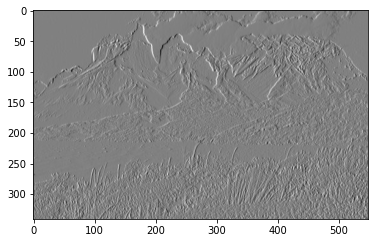

In [9]:
# Convolution can be used for many image processing applications.
# For instance, we can define a filter to detect edges in an image
edge_filter = torch.tensor([[[[-0.5, 0., 0.5], [-1., 0., 1.], [-0.5, 0., 0.5]]]])

# Then, we define a convolution and set the weights (=the kernel parameters) to this filter
my_conv = nn.Conv2d(1, 1, kernel_size=3, bias=False)
my_conv.weight = nn.Parameter(edge_filter, requires_grad=False)

# And now we apply convolution to the input image and get the edges
print(image_t.shape)
output = my_conv(image_t)
output_np = output.squeeze().detach().numpy()
plt.imshow(output_np, cmap='gray')
plt.show()

### PADDING

As remarked above, applying convolution reduces the dimension of the image as an edge effect. However, it's sometimes good to control the output dimension (e.g., to keep it the same as the input dimension). To do this, we can use padding, which consists in adding extra zeros on the four sides of the image: by artifically increasing the input image, we compensate for the dimension reduction in the output.

<img src="https://miro.medium.com/max/395/1*1okwhewf5KCtIPaFib4XaA.gif"/>
<center><a href="https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d">Source</a></center>

In the example above, using padding = 1 on each side compensates for the reduction due to a kernel size of 3.

In [10]:
# Create and apply a convolution without or with padding
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=3, bias=False)
output = my_conv(image_t)
my_conv_padd = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=3, padding=1, bias=False)
output_padd = my_conv_padd(image_t)

# Check the size
print('Input shape :', image_t.shape)
print('Output shape, no padding: ', output.shape)
print('Output shape, no padding: ', output_padd.shape)

Input shape : torch.Size([1, 1, 343, 550])
Output shape, no padding:  torch.Size([1, 1, 341, 548])
Output shape, no padding:  torch.Size([1, 1, 343, 550])


In [11]:
# TO DO: write a convolution with a kernel_size=5 (1 output channel, no bias)
# How much padding do you need to keep the image size the same?
# Same question with a non-square kernel of size=(9, 13) (padding can also be non-square)
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=5, padding=2, bias=False)
output = my_conv(image_t)
print(image_t.shape, output.shape)

my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(9,13), padding=(4,6), bias=False)
output = my_conv(image_t)
print(image_t.shape, output.shape)

torch.Size([1, 1, 343, 550]) torch.Size([1, 1, 343, 550])
torch.Size([1, 1, 343, 550]) torch.Size([1, 1, 343, 550])


### STRIDE

Stride means that we don't process/filter every adjacent block of pixels, but we "jump" from one to another. When we create a convolution, `stride=1` by default.

<img src="https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif" />
<center><a href="https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d">Source</a></center>

On the illustration above, the stride is 2.

Shape :  (172, 275)


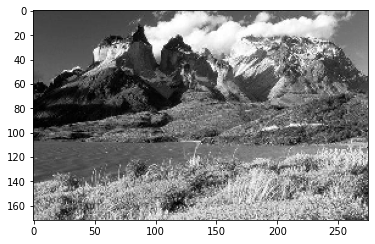

In [12]:
# Create a convolution with a kernel_size=1, weights equal to 1, but with a stride of 2:
# it's equivalent to removing every other pixel (or down-sampling the image)
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=1, stride=2, bias=False)
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
output = my_conv(image_t)
output_np = output.squeeze().detach().numpy()

print('Shape : ', output_np.shape)
plt.imshow(output_np, cmap='gray')
plt.show()

Shape :  (35, 55)


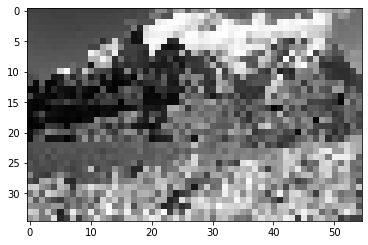

Shape :  (343, 184)


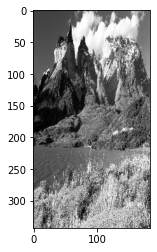

In [13]:
# TO DO: create and apply the same convolution as above, but with a stride of 10
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=1, stride=10, bias=False)
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
output = my_conv(image_t)
output_np = output.squeeze().detach().numpy()

print('Shape : ', output_np.shape)
plt.imshow(output_np, cmap='gray')
plt.show()

# TO DO: same, but with non-square stride = (1, 3)
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=1, stride=(1, 3), bias=False)
my_conv.weight = nn.Parameter(torch.ones_like(my_conv.weight), requires_grad=False)
output = my_conv(image_t)
output_np = output.squeeze().detach().numpy()

print('Shape : ', output_np.shape)
plt.imshow(output_np, cmap='gray')
plt.show()


### Pooling

For image classification / object detection, it is common in CNNs to apply a pooling function after convolution. Indeed, convolution produces output images where the important features (e.g., the detected object) might be spread over the image. The goal of pooling is to obtain a more compact representation of the image to avoid this spread (a property known as "local translation invariance"). As a result, a classification network is less sensitive to shift/translation in the image.

<img src="https://miro.medium.com/max/700/1*gaD6SJ6kQNVOclE_WkwLNQ.png" />
<center><a href="https://medium.com/nerd-for-tech/convolutional-networks-b54335f4e21f">Source</a></center>

The example above uses a max pooling function with a size of 2 and a stride of 2 (by default in pytorch, the stride is equal to the size of the pooling).


torch.Size([1, 1, 68, 109])


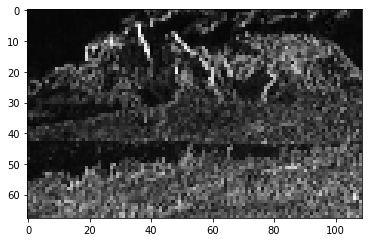

In [14]:
# Let's reuse our edge filter
my_conv = nn.Conv2d(1, 1, kernel_size=3, bias=False)
my_conv.weight = nn.Parameter(edge_filter, requires_grad=False)
output = my_conv(image_t)

# We now add a Max Pooling function after that
my_pool = nn.MaxPool2d(kernel_size =5)
output = my_pool(output)
print(output.shape)

# Plot the result: it should be a downsampled edge image
output_np = output.squeeze().detach().numpy()
plt.imshow(output_np, cmap='gray')
plt.show()

torch.Size([1, 1, 343, 550]) torch.Size([1, 1, 2, 3])


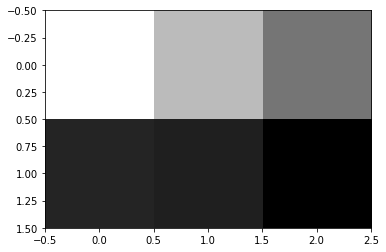

In [15]:
# TO DO: starting from the example above, stack sequentially {convolution + max pooling} three times.
# - the convolution is the same as the example above (with edge filter)
# - the pooling layer has a kernel-size=5
# - the CNN repeats {convolion + max pooling} 3 times (hint: use nn.Sequential)
# Plot the output. What do you see?

my_conv = nn.Conv2d(1, 1, kernel_size=3, bias=False)
my_conv.weight = nn.Parameter(edge_filter, requires_grad=False)
my_pool = nn.MaxPool2d(kernel_size =5)
my_cnn = nn.Sequential(my_conv, my_pool, my_conv, my_pool, my_conv, my_pool)

output = my_cnn(image_t)
print(image_t.shape, output.shape)
output_np = output.squeeze().detach().numpy()
plt.imshow(output_np, cmap='gray')
plt.show()

### TRANSPOSED CONVOLUTION

As seen above, convolution usually reduces the size of the image. In some applications (e.g., image synthesis from low-dimension features) it is usefull to increase it. This is exactly what transposed convolution does. Simply put, a transposed convolution adds some zeros inside the input image (and on the edge) to artificially increase the size.

Convolution             |  Transposed convolution
:-------------------------:|:-------------------------:
![](https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif)  |  ![](https://miro.medium.com/max/395/1*Lpn4nag_KRMfGkx1k6bV-g.gif)

<center><a href="https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d">Source</a></center>

On the left, we use convolution with a kernel size of 3 and stride of 2. On the right, we then use a transpoed convolution with the same parameters, and its effect is to procude an image with the same size as the original.

Note that transposed convolution does not invert convolution (it's not "deconvolution"): it only guarantees that the size will be equal to that of the image before convolution (but not its pixel values).

In [16]:
# First, let us apply a convolution with a kernel size of (3, 6) and a stride of 4.
my_conv = nn.Conv2d(1, 1, kernel_size=(3, 6), stride=4, bias=False)
output = my_conv(image_t)
print('Original image: ', image_t.shape)
print('Output of the convolution : ', output.shape)

# If we want to reproduce an image with the same size as the original input, we use ConvTranspose2d with the same parameters
my_convt = nn.ConvTranspose2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4, bias=False)
image_convt = my_convt(output)
print('After applying transposed convolution : ', image_convt.shape)

Original image:  torch.Size([1, 1, 343, 550])
Output of the convolution :  torch.Size([1, 1, 86, 137])
After applying transposed convolution :  torch.Size([1, 1, 343, 550])


In [17]:
# TO DO:
# - create an image-like tensor of size (64, 1, 28, 28) (hint: use torch.randn)
# - write a convolution function which outputs 7 x 7 images (size=(64, 1, 7, 7))  (it's up to you to choose kernel_size, padding, stride...)
# - write a transpoed convolution function which expands the 7 x 7 images back to 28 x 28

image_data = torch.randn(64, 1, 28, 28)
print(image_data.shape)

my_conv = nn.Conv2d(1, 1, kernel_size=3, stride=4)
output = my_conv(image_data)
print(output.shape)

my_convt = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=4)
output_t = my_convt(output)
print(output_t.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 7, 7])
torch.Size([64, 1, 27, 27])
